# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

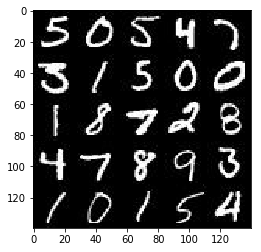

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

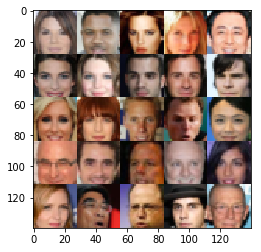

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    training = True
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.8)
        
        x = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.8)
        
        x = tf.layers.conv2d(images, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.8)
        
        # x = tf.layers.conv2d(images, 512, 5, strides=2, padding='same')
        # x = tf.layers.batch_normalization(x, training=training)
        # x = tf.maximum(alpha * x, x)
        # x = tf.layers.dropout(x, 0.3)
        
        logits = tf.layers.dense(tf.reshape(x, (-1, 7 * 7 * 512)), 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """        
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7 * 7 * 512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # x = tf.nn.relu(x)
        x = tf.layers.dropout(x, 0.8)
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # x = tf.nn.relu(x)
        x = tf.layers.dropout(x, 0.8)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # x = tf.nn.relu(x)
        x = tf.layers.dropout(x, 0.8)
        # 14 x 14 x 128
        
        # x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding='same')
        # x = tf.layers.batch_normalization(x, training=is_train)
        # x = tf.maximum(alpha * x, x)
        # 28 x 28 x 64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28 x 28 x out_channel_dim
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_output = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    
    d_output_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                      logits=d_logits_real,
                      labels=tf.ones_like(d_output_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                      logits=d_logits_fake,
                      labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_fake,
                    labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    show_every = 500
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2, smooth=0)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_images = batch_images * 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                if step % (show_every // 10) == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images,
                                                input_z: batch_z,
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch %2d/%2d d_loss: %.4f g_loss %.4f" 
                          % (epoch_i + 1, epoch_count, train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch  1/ 2 d_loss: 2.3563 g_loss 0.1496
Epoch  1/ 2 d_loss: 1.8445 g_loss 0.3197
Epoch  1/ 2 d_loss: 2.1929 g_loss 0.1542
Epoch  1/ 2 d_loss: 2.0171 g_loss 0.2134
Epoch  1/ 2 d_loss: 1.8270 g_loss 0.2783
Epoch  1/ 2 d_loss: 1.7677 g_loss 0.8441
Epoch  1/ 2 d_loss: 1.7446 g_loss 0.5563
Epoch  1/ 2 d_loss: 1.6894 g_loss 0.7123
Epoch  1/ 2 d_loss: 1.6303 g_loss 0.7451
Epoch  1/ 2 d_loss: 1.6696 g_loss 0.4424


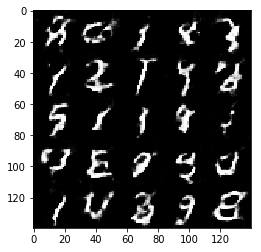

Epoch  1/ 2 d_loss: 1.7043 g_loss 0.6364
Epoch  1/ 2 d_loss: 1.8045 g_loss 0.2584
Epoch  1/ 2 d_loss: 1.6842 g_loss 0.3394
Epoch  1/ 2 d_loss: 1.5410 g_loss 1.0493
Epoch  1/ 2 d_loss: 1.7602 g_loss 0.2780
Epoch  1/ 2 d_loss: 1.5432 g_loss 0.7807
Epoch  1/ 2 d_loss: 1.6594 g_loss 0.3294
Epoch  1/ 2 d_loss: 1.5197 g_loss 0.6241
Epoch  1/ 2 d_loss: 1.6991 g_loss 0.9472
Epoch  1/ 2 d_loss: 1.5365 g_loss 0.6329


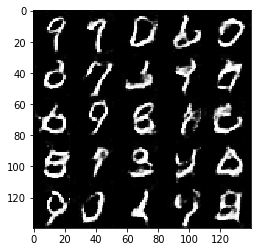

Epoch  1/ 2 d_loss: 1.6452 g_loss 0.3775
Epoch  1/ 2 d_loss: 1.5213 g_loss 0.6645
Epoch  1/ 2 d_loss: 1.7460 g_loss 0.2846
Epoch  1/ 2 d_loss: 1.5698 g_loss 0.8351
Epoch  1/ 2 d_loss: 1.7243 g_loss 0.3253
Epoch  1/ 2 d_loss: 1.6599 g_loss 0.5416
Epoch  1/ 2 d_loss: 1.4994 g_loss 0.5951
Epoch  1/ 2 d_loss: 1.6187 g_loss 0.3482
Epoch  1/ 2 d_loss: 1.6230 g_loss 0.8752
Epoch  1/ 2 d_loss: 1.5736 g_loss 0.5598


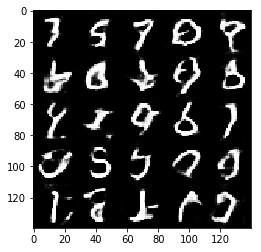

Epoch  1/ 2 d_loss: 1.6633 g_loss 0.3920
Epoch  1/ 2 d_loss: 1.6965 g_loss 0.9608
Epoch  1/ 2 d_loss: 1.7033 g_loss 0.3278
Epoch  1/ 2 d_loss: 1.5191 g_loss 0.5953
Epoch  1/ 2 d_loss: 1.5511 g_loss 0.4563
Epoch  1/ 2 d_loss: 1.5444 g_loss 0.4506
Epoch  1/ 2 d_loss: 1.5514 g_loss 0.4573
Epoch  2/ 2 d_loss: 1.4848 g_loss 0.7259
Epoch  2/ 2 d_loss: 1.5113 g_loss 0.6696
Epoch  2/ 2 d_loss: 1.5416 g_loss 0.6959


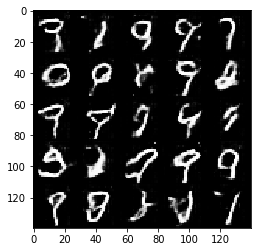

Epoch  2/ 2 d_loss: 1.4205 g_loss 0.7542
Epoch  2/ 2 d_loss: 1.5571 g_loss 0.7602
Epoch  2/ 2 d_loss: 1.4990 g_loss 0.6350
Epoch  2/ 2 d_loss: 1.4788 g_loss 0.6621
Epoch  2/ 2 d_loss: 1.4783 g_loss 0.5900
Epoch  2/ 2 d_loss: 1.5329 g_loss 0.4327
Epoch  2/ 2 d_loss: 1.5020 g_loss 0.4570
Epoch  2/ 2 d_loss: 1.4687 g_loss 0.5364
Epoch  2/ 2 d_loss: 1.5573 g_loss 0.5150
Epoch  2/ 2 d_loss: 1.6105 g_loss 0.3771


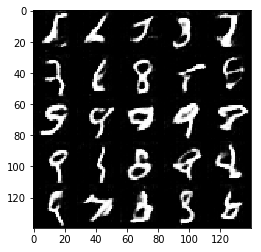

Epoch  2/ 2 d_loss: 1.4777 g_loss 0.6349
Epoch  2/ 2 d_loss: 1.4430 g_loss 0.7941
Epoch  2/ 2 d_loss: 1.5185 g_loss 0.5437
Epoch  2/ 2 d_loss: 1.4157 g_loss 0.7178
Epoch  2/ 2 d_loss: 1.4508 g_loss 0.8680
Epoch  2/ 2 d_loss: 1.5803 g_loss 0.7721
Epoch  2/ 2 d_loss: 1.5476 g_loss 0.4145
Epoch  2/ 2 d_loss: 1.5085 g_loss 0.4633
Epoch  2/ 2 d_loss: 1.5611 g_loss 0.7526
Epoch  2/ 2 d_loss: 1.6278 g_loss 0.3595


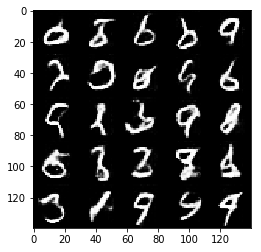

Epoch  2/ 2 d_loss: 1.4470 g_loss 0.5340
Epoch  2/ 2 d_loss: 1.5078 g_loss 0.7287
Epoch  2/ 2 d_loss: 1.6104 g_loss 0.8952
Epoch  2/ 2 d_loss: 1.5740 g_loss 0.4236
Epoch  2/ 2 d_loss: 1.5701 g_loss 0.4511
Epoch  2/ 2 d_loss: 1.4584 g_loss 0.5598
Epoch  2/ 2 d_loss: 1.5949 g_loss 0.3842
Epoch  2/ 2 d_loss: 1.5470 g_loss 0.4166
Epoch  2/ 2 d_loss: 1.4812 g_loss 0.5536
Epoch  2/ 2 d_loss: 1.5291 g_loss 0.7896


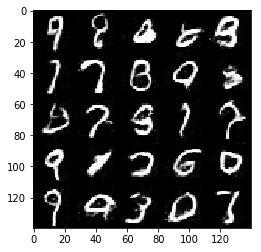

Epoch  2/ 2 d_loss: 1.4715 g_loss 0.6301
Epoch  2/ 2 d_loss: 1.4492 g_loss 0.5661
Epoch  2/ 2 d_loss: 1.4903 g_loss 0.7581
Epoch  2/ 2 d_loss: 1.3941 g_loss 0.6625
Epoch  2/ 2 d_loss: 1.4777 g_loss 0.5707


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch  1/ 1 d_loss: 3.2503 g_loss 0.0796
Epoch  1/ 1 d_loss: 3.8081 g_loss 0.0624
Epoch  1/ 1 d_loss: 2.6866 g_loss 0.8972
Epoch  1/ 1 d_loss: 2.5998 g_loss 0.2670
Epoch  1/ 1 d_loss: 2.7702 g_loss 0.8565
Epoch  1/ 1 d_loss: 2.0790 g_loss 0.2592
Epoch  1/ 1 d_loss: 2.6662 g_loss 1.1249
Epoch  1/ 1 d_loss: 2.1676 g_loss 0.4588
Epoch  1/ 1 d_loss: 1.7964 g_loss 0.3843
Epoch  1/ 1 d_loss: 2.1824 g_loss 0.2007


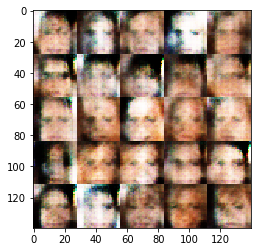

Epoch  1/ 1 d_loss: 2.2557 g_loss 0.2279
Epoch  1/ 1 d_loss: 2.1910 g_loss 0.8650
Epoch  1/ 1 d_loss: 2.0036 g_loss 0.7541
Epoch  1/ 1 d_loss: 2.1045 g_loss 0.2131
Epoch  1/ 1 d_loss: 1.7452 g_loss 0.4049
Epoch  1/ 1 d_loss: 1.7835 g_loss 0.3914
Epoch  1/ 1 d_loss: 1.8454 g_loss 0.7063
Epoch  1/ 1 d_loss: 1.7565 g_loss 0.4023
Epoch  1/ 1 d_loss: 1.8635 g_loss 0.7251
Epoch  1/ 1 d_loss: 1.8336 g_loss 0.8027


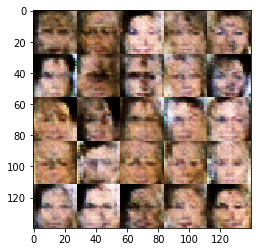

Epoch  1/ 1 d_loss: 1.8778 g_loss 0.7059
Epoch  1/ 1 d_loss: 1.9584 g_loss 0.2926
Epoch  1/ 1 d_loss: 1.9704 g_loss 0.8867
Epoch  1/ 1 d_loss: 1.7598 g_loss 0.5817
Epoch  1/ 1 d_loss: 1.8531 g_loss 0.3471
Epoch  1/ 1 d_loss: 1.5965 g_loss 0.7245
Epoch  1/ 1 d_loss: 1.6998 g_loss 0.6862
Epoch  1/ 1 d_loss: 1.6590 g_loss 0.8800
Epoch  1/ 1 d_loss: 1.5407 g_loss 0.6050
Epoch  1/ 1 d_loss: 1.6428 g_loss 0.4642


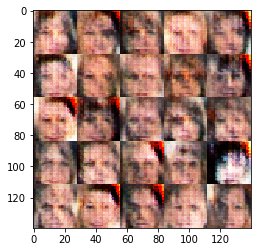

Epoch  1/ 1 d_loss: 1.7167 g_loss 0.5098
Epoch  1/ 1 d_loss: 1.7752 g_loss 0.6551
Epoch  1/ 1 d_loss: 1.7248 g_loss 0.6925
Epoch  1/ 1 d_loss: 1.7171 g_loss 0.5486


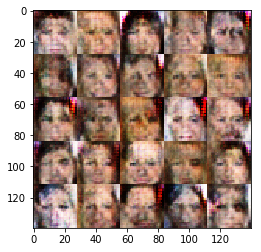

Epoch  1/ 1 d_loss: 1.6380 g_loss 0.6776
Epoch  1/ 1 d_loss: 1.7008 g_loss 0.4440
Epoch  1/ 1 d_loss: 1.5584 g_loss 0.7304
Epoch  1/ 1 d_loss: 1.6425 g_loss 0.5050
Epoch  1/ 1 d_loss: 1.9242 g_loss 0.4180
Epoch  1/ 1 d_loss: 1.6248 g_loss 0.5290
Epoch  1/ 1 d_loss: 1.5076 g_loss 0.6620
Epoch  1/ 1 d_loss: 1.5927 g_loss 0.5088
Epoch  1/ 1 d_loss: 1.4910 g_loss 0.5502
Epoch  1/ 1 d_loss: 1.7402 g_loss 0.8221


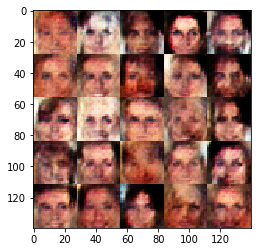

Epoch  1/ 1 d_loss: 1.6005 g_loss 0.7046
Epoch  1/ 1 d_loss: 1.5968 g_loss 0.7478
Epoch  1/ 1 d_loss: 1.7173 g_loss 0.4475
Epoch  1/ 1 d_loss: 1.5537 g_loss 0.7730
Epoch  1/ 1 d_loss: 1.5907 g_loss 0.5423
Epoch  1/ 1 d_loss: 1.5747 g_loss 0.5185
Epoch  1/ 1 d_loss: 1.5850 g_loss 0.7504
Epoch  1/ 1 d_loss: 1.5747 g_loss 0.4931
Epoch  1/ 1 d_loss: 1.6465 g_loss 0.5819
Epoch  1/ 1 d_loss: 1.6884 g_loss 0.5661


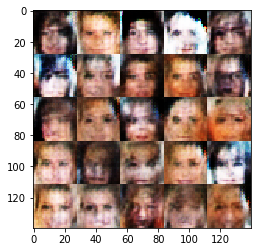

Epoch  1/ 1 d_loss: 1.5062 g_loss 0.6027
Epoch  1/ 1 d_loss: 1.4971 g_loss 0.6875
Epoch  1/ 1 d_loss: 1.5689 g_loss 0.5882


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.